# Updated single qubit operations 

In [1]:
# Import all necessary packages

# here are the objects that we use to create a quantum circuit in qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np
from qiskit.circuit.library import iqp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import random_hermitian
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector, plot_histogram
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qiskit import QuantumCircuit , transpile
from qiskit.visualization import plot_state_city, plot_state_hinton, plot_state_qsphere

from IPython.display import Markdown
from PIL import Image
from IPython.display import Image as IPImage
import io


## 2. Single Qubit gates and transformations 
### The Pauli Gates (X, Y & Z Gates)
We will now learn about some common quantum gates that will be used to transform our states.

The Pauli X, Y, and Z gates are operations that rotate a single qubit $180^\circ$ ($\pi$ radians) around the corresponding X, Y, or Z axis of the Bloch sphere.

For now we will consider how these gates impact the state $\ket{0}$, the initial value of every qubit in `qiskit`.

#### The X-Gate (Quantum `not`)
The Pauli X-gate corresponds to a rotation around the x-axis. This means it will flip state $\ket{0}$ to state $\ket{1}$ and visa versa making it analogous to a classical `not` operation.

#### The Y gate
The Y-gate does a $\pi$ radian rotation about the Y-axis

#### The Z-Gate
The Z-gate performs a $\pi$ radian rotation around the Z-axis.

Lets apply the different rotation gates to the states below:

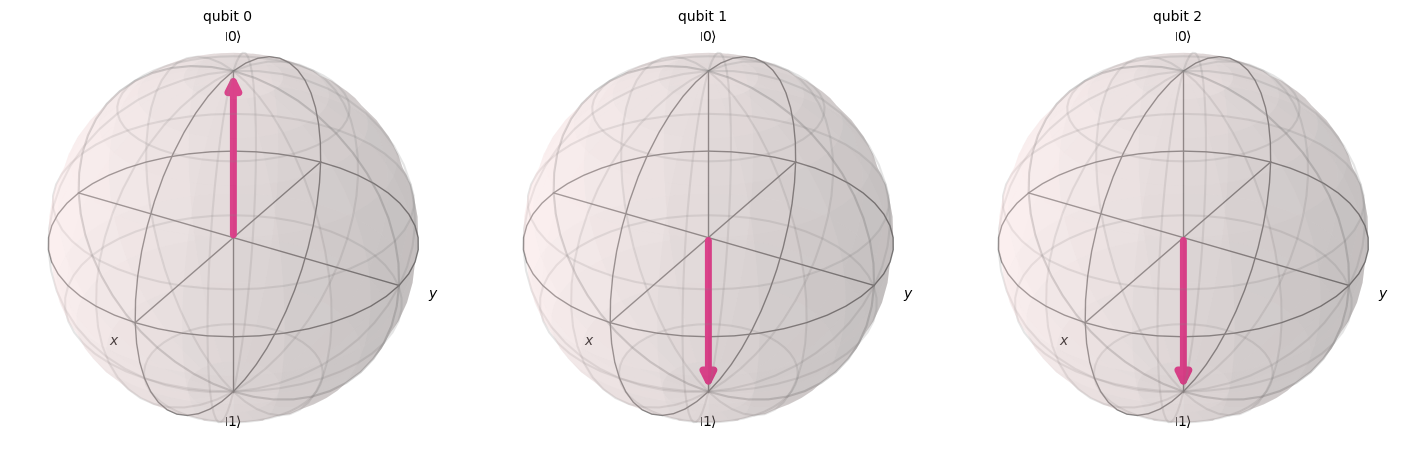

In [5]:
QuCirc = QuantumCircuit(3) #Initialize a quantum circuit with 3 qubits

QuCirc.x(1) #Apply x gate to first qubit
QuCirc.y(2)
QuCirc.z(2)
QuCirc.draw('mpl')

display(plot_bloch_multivector(QuCirc))

#### Question:
- Why does quibit 2 not rotate?

#### Fiddle
Let's initialize some qubit states and see how the X, Y and Z gates effect them.

#### Challenge
- Can you use X, Y and Z gates to invert all six initial states?
That is transform $\ket{0}\leftrightarrow\ket{1}$, $\ket{+}\leftrightarrow\ket{-}$ and $\ket{i}\leftrightarrow\ket{-i}$ (these are `l` and `r` in qiskit).

- **Bonus:** Do the inversion by apply every gate you add to *all* six qubits simultaneously.

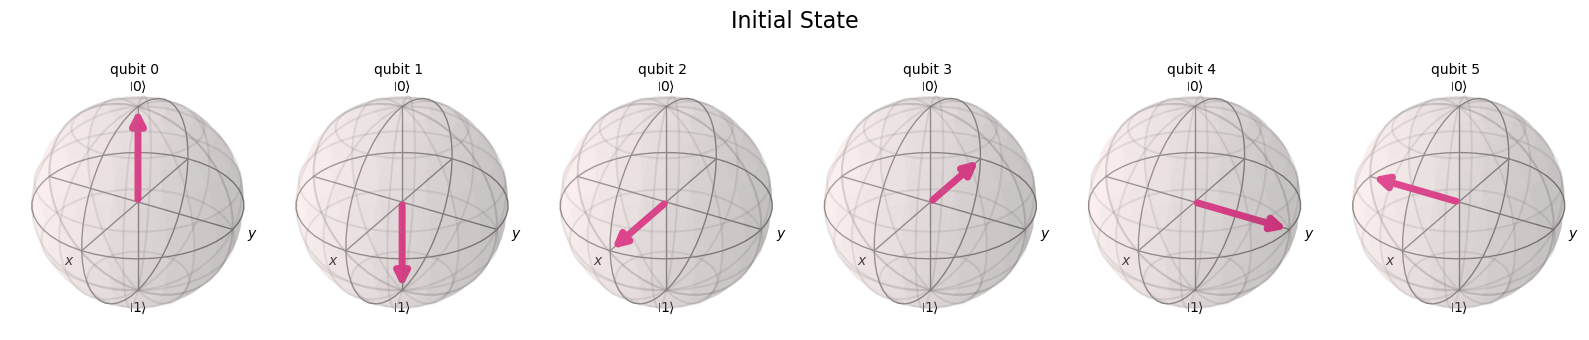

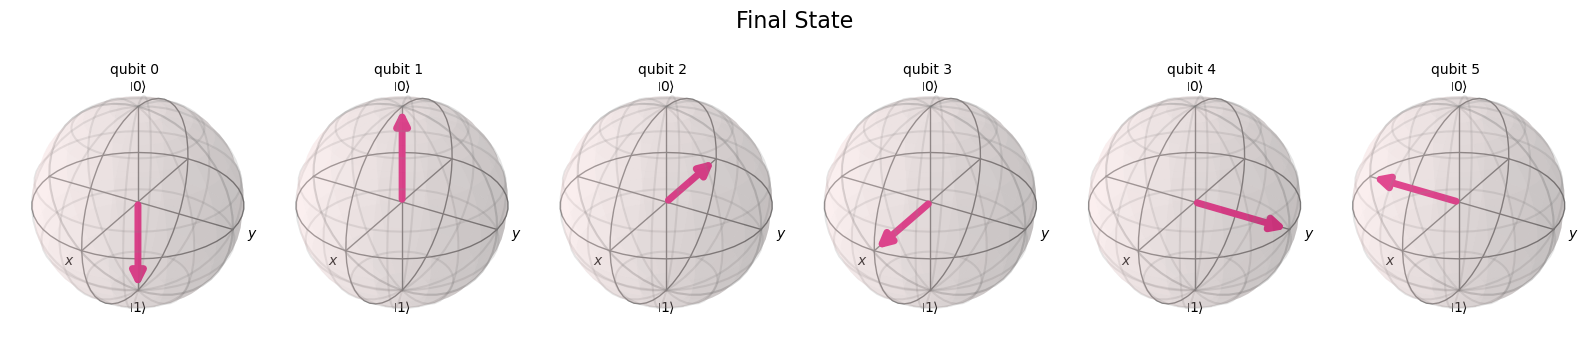

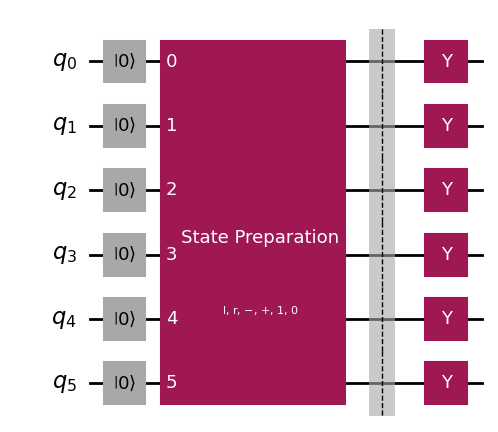

In [8]:
# Initialize qubit states 
QuCirc = QuantumCircuit(6)
QuCirc.initialize('01+-rl'[::-1],range(6)) # Play around with `01+-rl` to change the initial states
QuCirc = QuCirc.decompose(reps=1) # Not needed but good to see what's going on when qubits are initialized 
QuCirc.barrier()

# Store initial state vector for reference 
initial_state = Statevector(QuCirc)


# Your gates go here...
QuCirc.y(range(6)) # A y gate on all qubits 





# Display qubit states
display(plot_bloch_multivector(initial_state, title="Initial State"))
display(plot_bloch_multivector(QuCirc, title="Final State"))

# Display Circuit
display(QuCirc.draw('mpl'))

### Mathematical Representation  
Recall that we describe qubits as a superposition of two states:
$$
\ket{\psi}=\alpha\ket{0}+\beta\ket{1}=\alpha
\begin{bmatrix}
    1\\0
\end{bmatrix}
+\beta
\begin{bmatrix}
    0\\1
\end{bmatrix}
=\begin{bmatrix}
    \alpha\\\beta
\end{bmatrix}
$$
Coefficients $\alpha$ and $\beta$ are complex values where $|\alpha|^2=\alpha\alpha^*$ and $|\beta|^2=\beta\beta^*$ are the probabilities of measuring `0` and `1` respectively.

#### Applying a Quantum Gate
We can then describe single qubit operation (gate) as a $2\times2$ complex matrix operator $U$ and apply it through mutilation:
$$
\ket{\psi'}=
\begin{bmatrix}
    \alpha'\\\beta'
\end{bmatrix}
= \begin{bmatrix}
    U_{0,0} & U_{0,1} \\
    U_{1,0} & U_{1,1}
\end{bmatrix}
\begin{bmatrix}
    \alpha\\\beta
\end{bmatrix}
=U\ket{\psi}
$$

**Note:** The indexing used for matrix values here matches how you would access them in `python`. For example $U_{1,0}$ is `u[1,0]`

The matrix operator $U$ is valid if, and only if, **probity is conserved**. This means that $U$ must be a unitary matrix such that 
$$
U^\dagger U = UU^\dagger=\mathbb{I}
$$
were $U^\dagger$ denotes the Hermitian Adjoint (complex conjugate) and $\mathbb{I}$ is the identity matrix.

#### X, Y and Z matrices  
The matrices for the Pauli gates are as follows:
$$
X=\begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}
\hspace{15pt}
Y=\begin{bmatrix}
0 & -i \\
i & 0
\end{bmatrix}
\hspace{15pt}
Z=\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$


#### Fiddle
- See how applying the Pauli gates works algebraically 

In [12]:
# These functions will help us visualize matrices in jupyter
from typing import Literal, Iterable
def fmt_complex(z:complex, fmt_str:str = "{:.2g}"):
    if z.imag == 0:
        return fmt_str.format(z.real)
    if z.real == 0: # We know imag is non-zero
        return fmt_str.format(z.imag)+'j'
    
    # No special case
    return fmt_str.format(z)

def mat2latex(matrix:Iterable|Iterable[Iterable], matrix_type:Literal['b', 'p', '']='b', fmt_str:str = "{:.2g}")->str:
    """
    Formats the given input `matrix` as a latex equation.

    Args:
        * `matrix_type` defines the brackets used, [`'b'`:[ ], `'p'`:( ), `''`:no brackets]
        * `fmt_str` is a python string format that is used to prase matrix entries as strings
    """
    matrix_str = f"\\begin{{{matrix_type}matrix}}\n"
    for row in matrix:
        if isinstance(row, Iterable):
            if isinstance(row, np.ndarray) and row.size == 1:
                matrix_str += fmt_complex(row.item(), fmt_str) + ' \\\\ \n'
                continue
            matrix_str += " & ".join([fmt_complex(v, fmt_str) for v in row]) + '\\\\ \n'
        else:
           
            matrix_str += fmt_complex(row, fmt_str) + ' \\\\ \n'
    matrix_str += f"\\end{{{matrix_type}matrix}}"
    return matrix_str

$$\begin{bmatrix}
0 & 1\\ 
1 & 0\\ 
\end{bmatrix}\begin{bmatrix}
1 \\ 
0 \\ 
\end{bmatrix}=\begin{bmatrix}
0 \\ 
1 \\ 
\end{bmatrix}$$

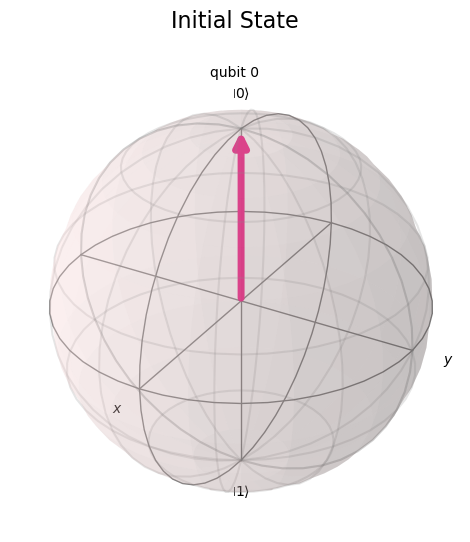

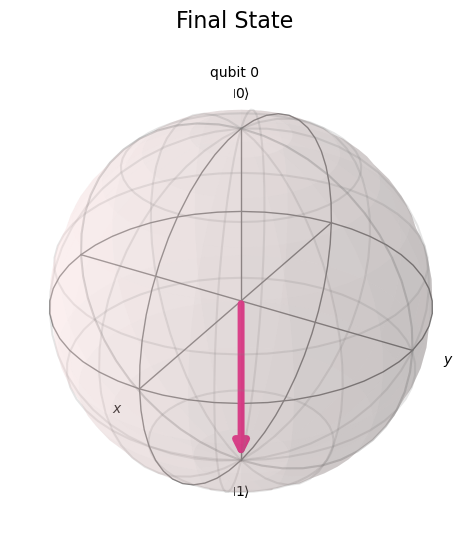

In [17]:
from qiskit.circuit.library import XGate, YGate, ZGate # These will let us get quantum gates as matrices

# Define our initial state, in this case |0>
initial_state = np.matrix([
    [1],
    [0]
], dtype=np.complex128)

# Ensure that input state is valid probability distribution
initial_state /= np.sqrt(np.sum(np.square(initial_state),axis=0))

# Example: Create an X gate matrix (Change this to anything you like)
operation = XGate().to_matrix()

# Apply the operation
final_state = operation * initial_state


display(Markdown(f"$${mat2latex(operation)}{mat2latex(initial_state)}={mat2latex(final_state)}$$"))

display(plot_bloch_multivector(Statevector(initial_state), title="Initial State"))
display(plot_bloch_multivector(Statevector(final_state), title="Final State"))


#### Question:
- Quantum gates *must* be unitary operation. What does this imply about their physical and computational properties?

#### Challenge:
- Edit the code above to include the inverse operation of each gate to show that the final state is the same as the initial.
The `.conj()` and `.transpose()` might be helpful.

## The Hadamard (H) Gate - Where the magic happens 

The power of quantum computing is in superposition

And to make superposition we use H-gates!

### Algebraic Description
The operator for this gate is as follows:
$$
H=\frac{1}{\sqrt{2}}\begin{bmatrix}1&1\\1&-1\end{bmatrix}
$$

Note that this matrix is not purely diagonal which means it will translate from the deterministic states $\ket{0}$ and $\ket{1}$ to the probabilistic states $\ket{+}$ and $\ket{-}$

Lets see how that works in code:

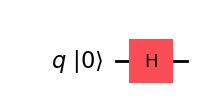

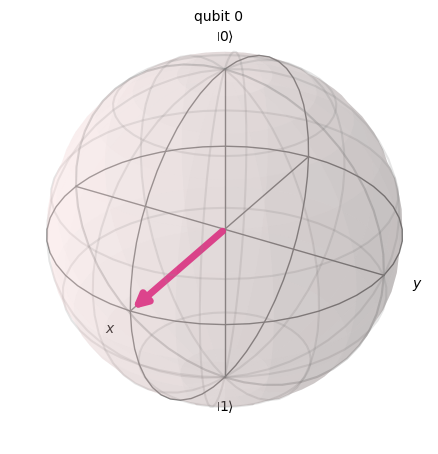

In [19]:
QuCirc = QuantumCircuit(1)
QuCirc.h(0)
display(QuCirc.draw('mpl', initial_state=True))

display(plot_bloch_multivector(QuCirc))

Apply the H-gate effects some more common qubit states:

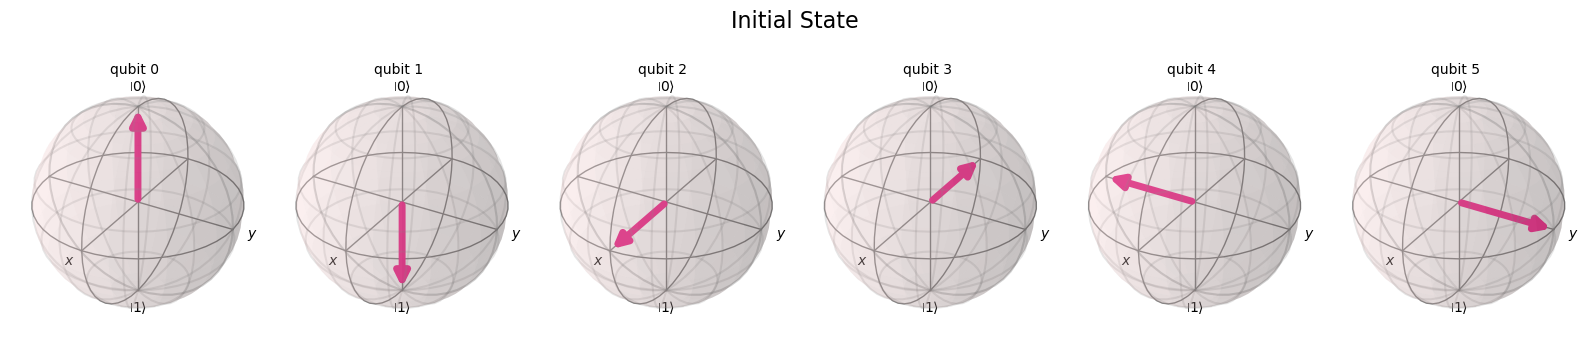

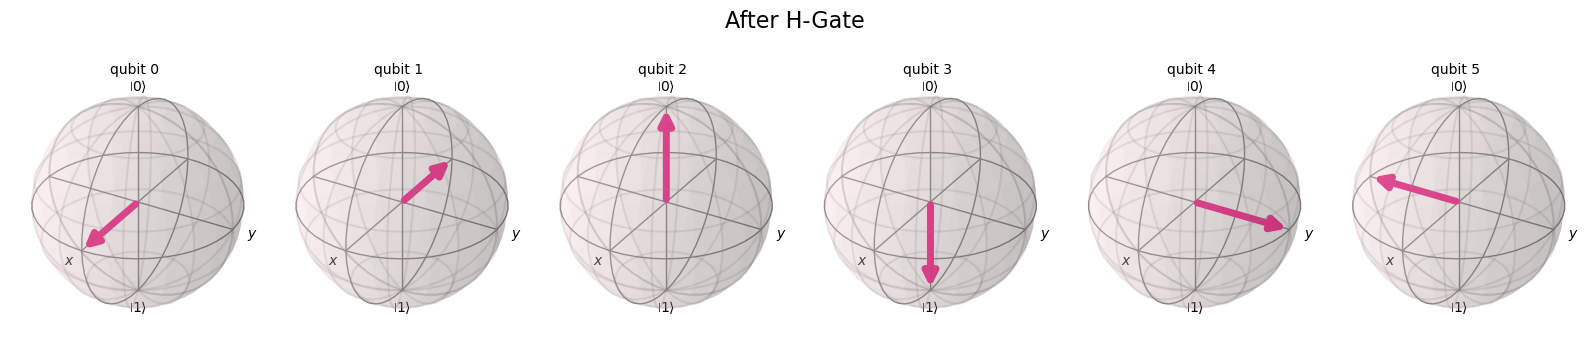

In [24]:
QuCirc = QuantumCircuit(6)
QuCirc.initialize('01+-lr'[::-1], range(6))
initial_state = Statevector(QuCirc)

QuCirc.h(range(6))

final_state = Statevector(QuCirc)

display(plot_bloch_multivector(Statevector(initial_state), title="Initial State"))
display(plot_bloch_multivector(Statevector(final_state), title="After H-Gate"))

#### Questions
- What is the inverse of the H-Gate?
- Is the H-Gate also a rotation?

### Arbitrary Rotations on any axis 
We can make arbitrary gates with even smaller rotations by following the same logic as the Pauli gates.
For example a $\frac\pi3$ radian ration would use the third primary root of unity of the respective Pauli gate for the axis of rotation.

So $\sqrt[3]{Z}$ is a $\frac \pi 3$ rotation around the Z-axis and more generally: $\sqrt[n]{Z}$ is a $\frac \pi n$ rotation.

In `qiskit` we can do this using generic `rz` gates.

If we wanted to rotate on the X or Y axis we could use `rx` and `ry` gates as well.

Try some combinations out below, mess about and have fun!

In [ ]:
QuCirc = QuantumCircuit(3)
QuCirc.rz(np.pi/3,0) #You have to specify the rotation angle and the target qubit in that order 
QuCirc.ry(np.pi/3,1) # For example this: `ry(np.pi/3,1)` rotates qubit 1 π/3 rad around the y axis.
QuCirc.rx(np.pi/3,2) 
display(plot_bloch_multivector(QuCirc))
display(QuCirc.draw('mpl', initial_state=True))

#### Question
- We now know how to move from probabilistic to deterministic states using quatre X and Y rotations. Is the H-gate still special?
- Why is The H-gate different?
- Why is that useful?

#### Let's have some fun
The code below can be used to make a gif of a rotating bloch vector.

For this example we are spinning around the Y axis but you can play around with different circuits gates in the for-loop 

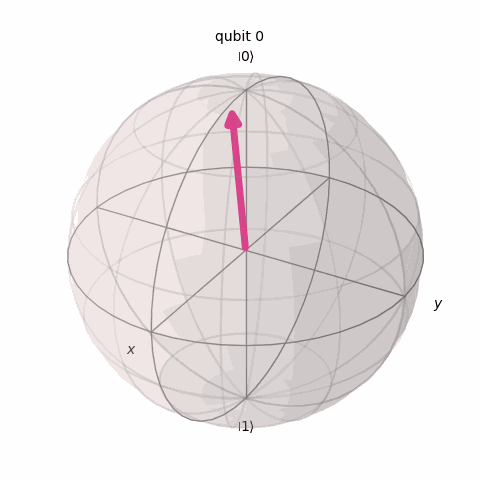

In [27]:
# Plotting the gif may take a short while...

# We will save many plots to make a gif 
frames = []

QuCirc = QuantumCircuit(1)

n_steps = 40

for n in range(n_steps):
    
    theta = 2*np.pi/n_steps
    QuCirc.ry(theta,0) # append another gate to the circuit, gates from previous loops all still apply


    plot = plot_bloch_multivector(QuCirc)


    # This will write our plot to the gif frames 
    buf = io.BytesIO()
    plot.savefig(buf, format='png')
    frames.append(Image.open(buf))



# Filename for our gif 
GIF_PATH = 'gif.gif'
# Save the gif
frames[0].save(GIF_PATH,
               save_all = True,
               #append_images = frames[1:] + frames[1:-2][::-1],
               append_images = frames[1:],
               duration = 100,
               loop=0)

# Display the gif
display(IPImage(data=open(GIF_PATH,'rb').read(), format='png'))

#### Challenge:
- You now learnt how to do arbitrary rotations. Try to apply an arbitrary set of rotations that traces out an interesting curve on the bloch sphere. 
- See if you can use frames and maybe a for loop to animate your traced curve as a gif
- **Bonus** can you parameterize your curve in a for loop?

**Tip**: If you want to remove all gates from a quantum circuit (maybe you need a 'clean slate' each loop) you can call `.clear()`.